In [1]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
from papers_segmented import plot_paper_detections, plot_segmented_papers

In [4]:
# Charger ton modèle entraîné
model = YOLO("../detection_model/Yolo-seg.pt")

In [5]:
import os
filenames = os.listdir(f"../paper_detection/test_set")
print(filenames)

['IMG-20250928-0023.jpg', 'IMG-20250928-WA0024.jpg', 'IMG-20250929-WA0001.jpg', 'IMG-20250929-WA0002.jpg', 'IMG-20250930-WA0003.jpg', 'IMG-20251001-WA0004.jpg', 'IMG-20251001-WA0005.jpg', 'IMG-20251001-WA0006.jpg', 'IMG-20251001-WA0007.jpg', 'IMG-20251001-WA0008.jpg', 'IMG-20251001-WA0009.jpg', 'IMG-20251001-WA0010.jpg', 'IMG-20251001-WA0011.jpg', 'IMG-20251001-WA0012.jpg', 'IMG-20251001-WA0013.jpg', 'IMG-20251001-WA0014.jpg', 'IMG-20251001-WA0015.jpg', 'IMG-20251001-WA0016.jpg', 'IMG-20251001-WA0017.jpg', 'IMG-20251001-WA0018.jpg', 'IMG-20251001-WA0019.jpg', 'IMG-20251001-WA0020.jpg', 'IMG-20251001-WA0021.jpg', 'IMG-20251001-WA0022.jpg']


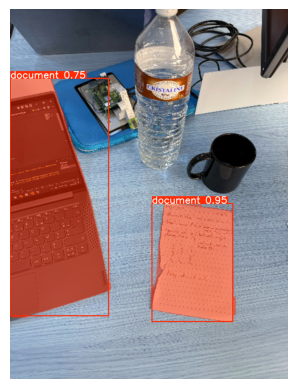

In [6]:
for i in filenames:
    plot_paper_detections(model, f"../paper_detection/test_set/{i}",seuil=0.5)
    break

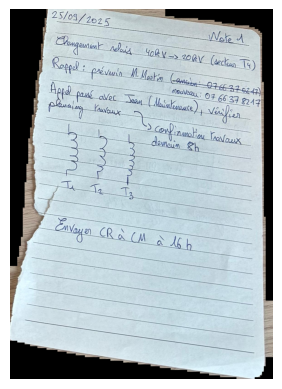

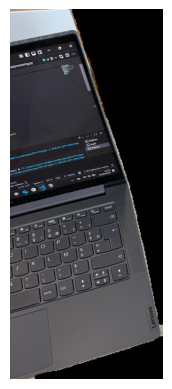

In [7]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

for i in filenames:
    plot_segmented_papers(model, f"../paper_detection/test_set/{i}", seuil=0.5)
    break

In [8]:
import cv2
import time
import numpy as np
from datetime import datetime
from ultralytics import YOLO
import os
from blurry_detection import less_blurred

BASE_DIR = os.getcwd()


# Modèle YOLOv11 finetuné sur le dataset https://app.roboflow.com/dty-opi9m/detection-de-feuilles-245oo/1/export
model_path = os.path.join(BASE_DIR, '../detection_model/Yolo-seg.pt')
model = YOLO(model_path)

OUTPUT_DIR = os.path.join(BASE_DIR, "output")
FRAMES_DIR = os.path.join(OUTPUT_DIR, "frames")
MASKS_DIR = os.path.join(OUTPUT_DIR, "masks")

# Création des dossiers si besoin
os.makedirs(FRAMES_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)

In [10]:

# Timer
start = time.time()
checkpoint = start

# Initialisation des outils de capture des objets
video = []

def save_masked_image(result, save_dir, stamp):
    orig = result.orig_img
    h, w = orig.shape[:2]

    if result.masks is not None and len(result.masks.data) > 0:
        for j, m in enumerate(result.masks.data.cpu().numpy()):
            # Redimensionner le masque
            m_resized = cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST)
            m_resized = (m_resized > 0.5).astype(np.uint8) * 255

            # Appliquer le masque
            masked = cv2.bitwise_and(orig, orig, mask=m_resized)

            # Recadrer autour du masque
            coords = cv2.findNonZero(m_resized)
            if coords is not None:
                x, y, bw, bh = cv2.boundingRect(coords)

                # Appliquer un dézoom de zoom_out (% du rectangle)
                margin_w = int(bw * 0.1)
                margin_h = int(bh * 0.1)

                x = max(0, x - margin_w)
                y = max(0, y - margin_h)
                bw = min(w - x, bw + 2 * margin_w)
                bh = min(h - y, bh + 2 * margin_h)
                
                cropped = masked[y:y+bh, x:x+bw]
            else:
                cropped = masked

            filename_masked = os.path.join(save_dir, f"object_{stamp}_{j}.jpg")
            cv2.imwrite(filename_masked, cropped)
            
            
# Lancement de la webcam
try :
    for result in model.predict(source = 0, show = True, conf = 0.8, verbose = False, stream = True):
        boxes = result.boxes
        if boxes and len(boxes)>0:      # Si un objet (une feuille de papier) est détectée sur la frame
            if len(video)==0:       # Si aucun objet n'était en cours de capture
                if time.time()-checkpoint>5:
                    checkpoint = time.time()
                    video.append(result)
            elif len(video)<20: # Si un objet est en cours de capture
                video.append(result)
            elif len(video)==20:    # Si on a fini de capturer l'objet
                best = less_blurred(video)  # Indice de la frame la moins floue
                stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

                filename_frame = os.path.join(BASE_DIR, "../../../tmp", f"photo_{stamp}.jpg")
                save_dir_object = os.path.join(BASE_DIR, "../../../tmp")
                
                # Sauvegarde masques (au lieu des boxes)
                save_masked_image(video[best], save_dir_object, stamp)
                
                video = []      # On réinitialise la sous-vidéo capturée
                
        elif len(video)>0:  # Si l'objet a disparu avant la fin de la capture des 20 frames
            best = less_blurred(video)  # Indice de la frame la moins floue
            stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

            filename_frame = os.path.join(BASE_DIR, "../../../tmp", f"photo_{stamp}.jpg")
            save_dir_object = os.path.join(BASE_DIR, "../../../tmp")
            
            save_masked_image(video[best], save_dir_object, stamp)                             # On enregistre la frame avec la bounding box tracée
            
            video = []      # On réinitialise la sous-vidéo capturée
except KeyboardInterrupt :
    print("Arrêt demandé par l'utilisateur.")
finally :
    print("Fin.")

1/1: 0... Success  (inf frames of shape 640x480 at 30.00 FPS)

Arrêt demandé par l'utilisateur.
Fin.
